# Dataset Overview and Quality Checks for Recommendation System

This notebook provides a comprehensive audit of the `authors_df` and `cleaned1` datasets. It includes:
1. **Data Loading** (Synthetic generation matching your stats vs. Real loading)
2. **General Overview** (Info, Head, Duplicates)
3. **Missing Value Analysis** (Visualizing sparsity)
4. **Distribution Analysis** (Author productivity, Fields)
5. **Integrity Checks** (Cross-referencing IDs between tables)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Set visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading
**NOTE:** The block below generates synthetic data that matches the exact counts (315 authors, 1635 articles) and sparsity (only 48 titles) from your provided `info()`. 

**To use your real data:** Comment out the "Synthetic Data" section and uncomment the "Real Data Loading" section.

In [9]:
authors_df = pd.read_csv('authors.csv')
cleaned1 = pd.read_csv('cleaned.csv')


## 2. General Overview

In [10]:
def overview(df, name):
    print(f"--- {name} ---")
    print(f"Shape: {df.shape}")
    print(f"Duplicates: {df.duplicated().sum()}")
    print("\nInfo:")
    df.info()
    print("\nFirst 3 rows:")
    display(df.head(3))
    print("="*50 + "\n")

overview(authors_df, "Authors DataFrame")
overview(cleaned1, "Articles DataFrame")

--- Authors DataFrame ---
Shape: (315, 3)
Duplicates: 0

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author         315 non-null    object
 1   article_ids    315 non-null    object
 2   article_count  315 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 7.5+ KB

First 3 rows:


,author,article_ids,article_count
0,*Hamedi Adnan,[22],1
1,ABDURRAUF HASSAN,[181],1
2,ABULHALIM BIN MOHAMAD,[181],1



--- Articles DataFrame ---
Shape: (1635, 7)
Duplicates: 0

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          48 non-null     object
 1   title_en       192 non-null    object
 2   general_field  1446 non-null   object
 3   authors        206 non-null    object
 4   source         1635 non-null   object
 5   path           1635 non-null   object
 6   id             1635 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 89.5+ KB

First 3 rows:


,title,title_en,general_field,authors,source,path,id
0,درجة اكتساب طلبة كلية التربية بجامعة السلطان ق...,The Level of Acquisition of Action Research Sk...,NaN,نور النجار,AJP,finalpdfs/AJP_1337_1.pdf,1
1,القيادة الاستباقية وعلاقتها بإدارة مخاطر البيئ...,Proactive Leadership and its Relationship to S...,NaN,"لانا عبد المولى العنزي, محمد عبود الحراحشة",AJP,finalpdfs/AJP_1338_2.pdf,2
2,درجة ممارسة معلمي اللغة العربية لمهارات التذوق...,The Degree to Which Arabic Language Teachers P...,NaN,أمل مد الله الشعراء,AJP,finalpdfs/AJP_1339_3.pdf,3


## 3. Missing Value Analysis
This is critical for a recommendation system. If `title` is missing, we cannot calculate text embeddings easily.

/tmp/ipykernel_14565/2267607351.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette="Reds_r")


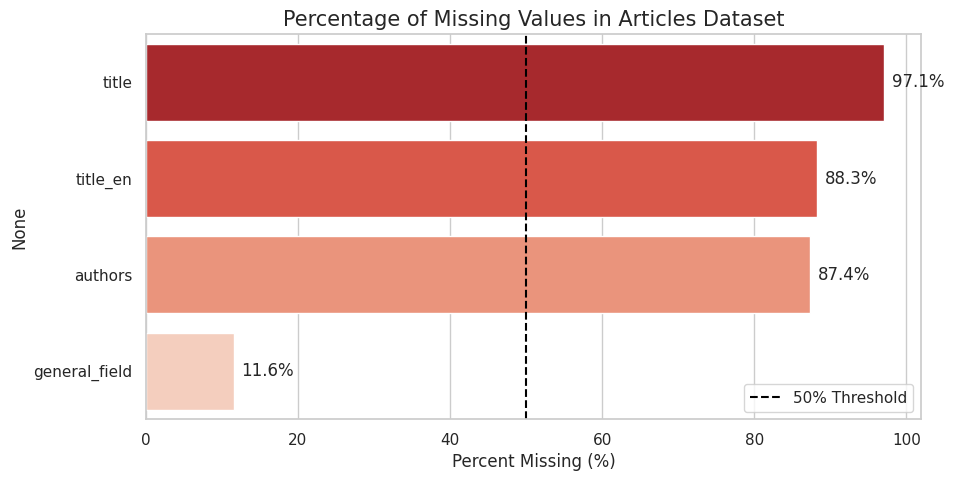

In [11]:
# Calculate missing percentages
missing = cleaned1.isnull().sum() / len(cleaned1) * 100
missing = missing[missing > 0].sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=missing.values, y=missing.index, palette="Reds_r")
plt.title("Percentage of Missing Values in Articles Dataset", fontsize=15)
plt.xlabel("Percent Missing (%)")
plt.axvline(x=50, color='black', linestyle='--', label='50% Threshold')
plt.legend()
for i, v in enumerate(missing.values):
    plt.text(v + 1, i, f"{v:.1f}%", va='center')

# Save figure
plt.savefig('figures/missing_values.png', bbox_inches='tight')
plt.show()

**Observation:**
- **Title:** Extremely high missing rate (~97%).
- **Title_EN:** High missing rate (~88%).
- **General Field:** Lower missing rate (~11%).
  
*Implication:* Cold-start recommendation strategies (using `general_field`) will be more effective than Content-Based strategies (using `title`) for this specific dataset.

## 4. Distribution Analysis

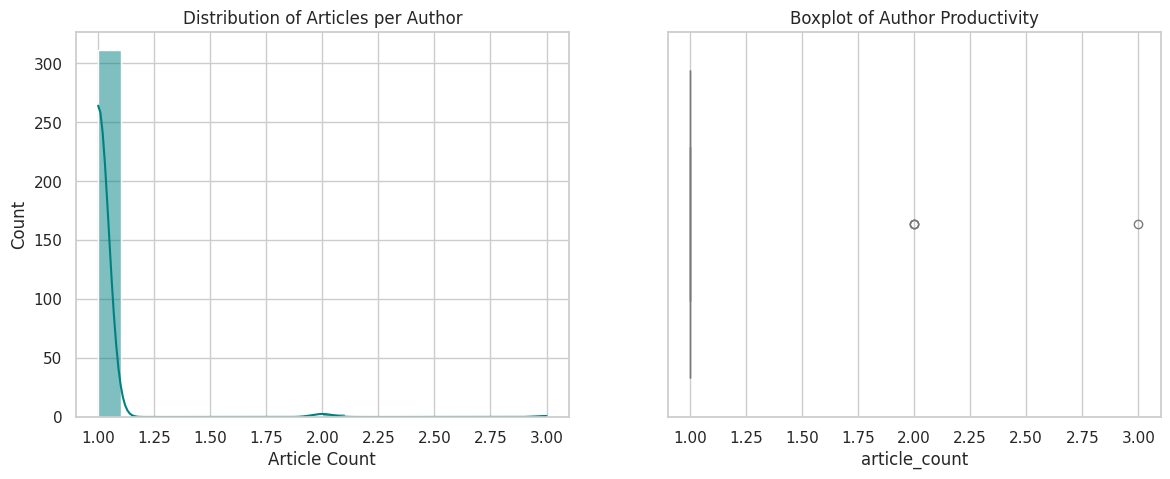

/tmp/ipykernel_14565/3412384845.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_fields.index, x=top_fields.values, palette='viridis')


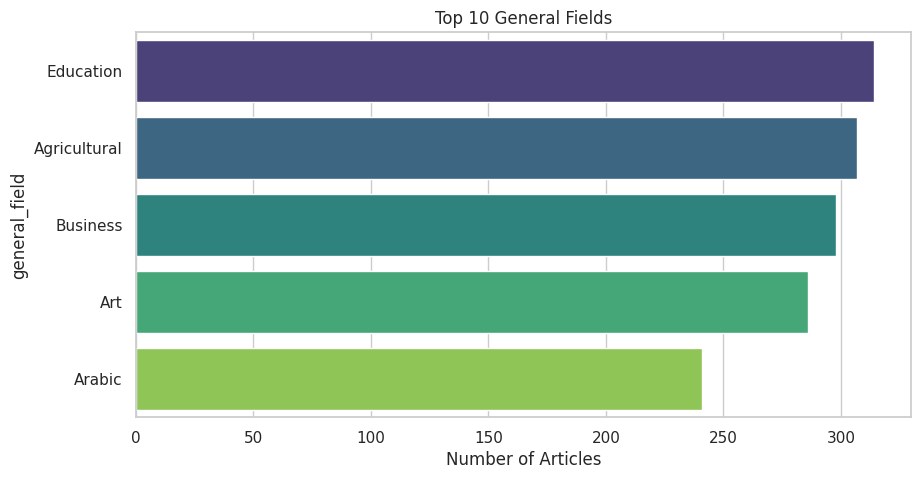

In [12]:
# --- 4.1 Author Productivity ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(authors_df['article_count'], bins=20, kde=True, color='teal')
plt.title("Distribution of Articles per Author")
plt.xlabel("Article Count")

plt.subplot(1, 2, 2)
sns.boxplot(x=authors_df['article_count'], color='lightblue')
plt.title("Boxplot of Author Productivity")

# Save figure
plt.savefig('figures/author_productivity.png', bbox_inches='tight')
plt.show()

# --- 4.2 Content Categories ---
plt.figure(figsize=(10, 5))
top_fields = cleaned1['general_field'].value_counts().head(10)
sns.barplot(y=top_fields.index, x=top_fields.values, palette='viridis')
plt.title("Top 10 General Fields")
plt.xlabel("Number of Articles")

# Save figure
plt.savefig('figures/top_fields.png', bbox_inches='tight')
plt.show()

## 5. Data Quality & Integrity Checks
Checking if the IDs referenced in `authors_df` actually exist in `cleaned1`.

In [13]:
# 1. Parse article_ids from string if necessary
def parse_ids(val):
    if isinstance(val, str):
        # Remove brackets and split
        val = val.replace('[', '').replace(']', '').split(',')
        # Convert to int, filter out empty strings
        return [int(x.strip()) for x in val if x.strip().isdigit()]
    elif isinstance(val, list):
        return val
    return []

# 2. Collect all referenced IDs
referenced_ids = []
for x in authors_df['article_ids']:
    referenced_ids.extend(parse_ids(x))

referenced_ids = set(referenced_ids)
existing_ids = set(cleaned1['id'].unique())

# 3. Check for Orphans
missing_ids = referenced_ids - existing_ids

print(f"Total unique article IDs referenced by authors: {len(referenced_ids)}")
print(f"Total unique article IDs actually in article DB: {len(existing_ids)}")
print(f"IDs referenced but missing from DB (Orphans): {len(missing_ids)}")

if len(missing_ids) > 0:
    print("\n[WARNING]: Some authors refer to articles that do not exist in the article table.")
else:
    print("\n[SUCCESS]: Integrity check passed. All referenced articles exist.")

Total unique article IDs referenced by authors: 206
Total unique article IDs actually in article DB: 1635
IDs referenced but missing from DB (Orphans): 0

[SUCCESS]: Integrity check passed. All referenced articles exist.


## 6. Recommendations
Based on the analysis:
1. **Impute Titles:** Try to fill `title` with `title_en` where `title` is missing (or vice versa).
2. **Feature Engineering:** Create a `combined_text` column that concatenates `general_field` + `source` + any available title to ensure every row has at least some content for the recommender.
3. **Cleaning:** Rows with `id` present but absolutely no metadata (no title, no field) should be dropped or flagged.